In [87]:
# read all the data from the csv files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# read the data from the csvs files in the folder
data = []
for file in os.listdir("."):
    if file.startswith("Metrics") and file.endswith(".csv"):
        data.append(pd.read_csv(file).to_dict('records')[0])
        data[-1]['step'] = file[16:-4] 
df = pd.DataFrame(data)
df.sort_values(by=['displayName'], inplace=True)
df

,displayName,status,createdOn,duration,gpt_coherence,gpt_coherence_pass_rate(%),gpt_fluency,gpt_fluency_pass_rate(%),gpt_groundedness,gpt_groundedness_pass_rate(%),gpt_relevance,gpt_relevance_pass_rate(%),step
1,eval_step_0,Completed,2023-10-10T11:50:28.0940673+00:00,60723.3949,4.14,82.14,4.15,75.00,3.41,42.86,2.71,39.29,baseline
0,eval_step_1,Completed,2023-10-10T12:55:50.6373248+00:00,76317.9513,2.69,42.86,3.48,64.29,3.64,46.43,2.96,46.43,system_prompt
2,eval_step_2,Completed,2023-10-10T13:30:19.1139808+00:00,753599.5701,3.37,51.85,3.96,81.48,3.85,55.56,3.04,48.15,chunk_size
3,eval_step_3,Completed,2023-10-10T13:48:24.1054048+00:00,58688.1524,3.57,64.29,3.81,71.43,4.43,78.57,3.61,64.29,infer_intent


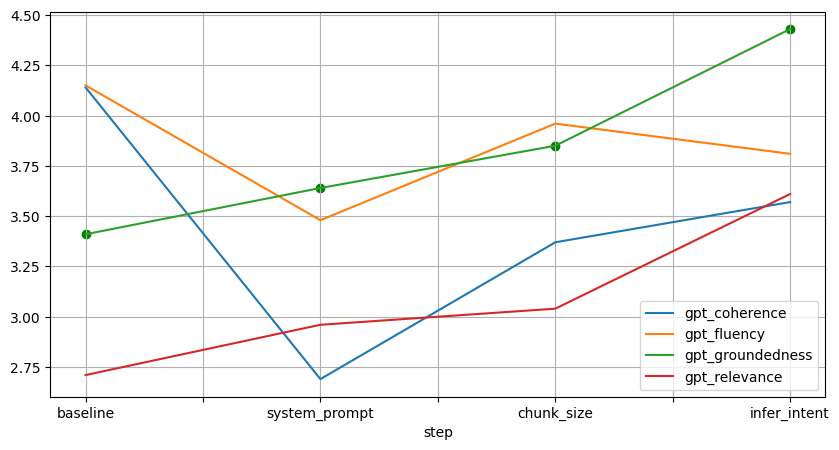

In [88]:
# create a line plot for the data
df_focused = df[['step', 'gpt_coherence', 'gpt_fluency', 'gpt_groundedness', 'gpt_relevance']]
df_focused.plot(x='step', figsize=(10, 5))
# add dots to the line plot
plt.scatter(df_focused['step'], df_focused['gpt_groundedness'], color='green')
# add a grid
plt.grid()
# save the plot
plt.savefig('metrics.png')


In [89]:
import tiktoken
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [90]:
import os
for document_name in os.listdir("../product_info"):
    document = open("../product_info/" + document_name, "r").read()
    tokens = encoding.encode(document)
    print("Document: ", document_name, "words:", len(document.split()) , " characters: ", len(document), " tokens: ", len(tokens))

Document:  product_info_2.md words: 1696  characters:  10787  tokens:  2147
Document:  product_info_10.md words: 1672  characters:  10700  tokens:  2215
Document:  product_info_6.md words: 2067  characters:  12939  tokens:  2701
Document:  product_info_14.md words: 1547  characters:  9668  tokens:  2044
Document:  product_info_20.md words: 1992  characters:  12465  tokens:  2580
Document:  product_info_7.md words: 1428  characters:  8702  tokens:  1872
Document:  product_info_15.md words: 1664  characters:  10174  tokens:  2217
Document:  product_info_3.md words: 1802  characters:  11391  tokens:  2344
Document:  product_info_11.md words: 1698  characters:  10649  tokens:  2240
Document:  product_info_8.md words: 1812  characters:  11050  tokens:  2306
Document:  product_info_9.md words: 1935  characters:  12839  tokens:  2529
Document:  product_info_18.md words: 1882  characters:  11604  tokens:  2445
Document:  product_info_19.md words: 1931  characters:  12172  tokens:  2434
Documen

In [121]:
from scipy import stats
def run_t_test(metric, control_name, treatment_name, control, treatment):
    df = pd.DataFrame({"control":control[metric].values, "treatment":treatment[metric].values})
    df.dropna(inplace=True)
    ttest_result = stats.ttest_rel(df.treatment, df.control)
    return dict(metric=metric, 
                control=control_name, 
                treatment=treatment_name, 
                control_mean=control[metric].mean(), 
                treatment_mean=treatment[metric].mean(),
                change_mean=treatment[metric].mean() - control[metric].mean(), 
                p_value=ttest_result.pvalue, 
                ci_low=ttest_result.confidence_interval()[0], 
                ci_high=ttest_result.confidence_interval()[1])   

In [122]:
# read all the data from the csv files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats

# read the data from the csvs files in the folder
data = pd.DataFrame()
for file in os.listdir("."):
    if file.startswith("Output") and file.endswith(".csv"):
        records = pd.read_csv(file)
        records['step'] = file[18:-4]
        # append the records to the data
        data  = pd.concat([data, records], ignore_index=True)

# group the data by step and aggregate gpt_coherence	gpt_fluency	gpt_groundedness	gpt_relevance
metrics = {}
for metric in ['gpt_coherence', 'gpt_fluency', 'gpt_groundedness', 'gpt_relevance']:
    metric_data = data[['step', metric]].copy()
    metric_data[metric] = metric_data.apply(lambda x: pd.to_numeric(x[metric], errors='coerce'), axis=1)
    #metric_data = metric_data.dropna()
    metrics[metric] = metric_data

# for each metric, do a t-test btw each of the steps in increasing order
# 0_baseline, 1_system_prompt, 2_chunk_size, 3_infer_intent
results = []
for metric, metric_data in metrics.items():
    steps = metric_data['step'].unique()
    steps.sort()
    for i in range(len(steps)-1):
        control = metric_data[metric_data['step'] == steps[i]]
        treatment = metric_data[metric_data['step'] == steps[i+1]]
        results.append(run_t_test(metric, steps[i], steps[i+1], control, treatment))
    # now compare the first and the last:
    control = metric_data[metric_data['step'] == steps[0]]
    treatment = metric_data[metric_data['step'] == steps[-1]]
    results.append(run_t_test(metric, steps[0], steps[-1], control, treatment))
    
# create a dataframe with the results
results_df = pd.DataFrame(results)
results_df

,metric,control,treatment,control_mean,treatment_mean,change_mean,p_value,ci_low,ci_high
0,gpt_coherence,0_baseline,1_system_prompt,4.142857,2.692308,-1.450549,0.000285,-2.061226,-0.708004
1,gpt_coherence,1_system_prompt,2_chunk_size,2.692308,3.370370,0.678063,0.046590,0.010040,1.220730
2,gpt_coherence,2_chunk_size,3_infer_intent,3.370370,3.571429,0.201058,0.494222,-0.363801,0.734172
3,gpt_coherence,0_baseline,3_infer_intent,4.142857,3.571429,-0.571429,0.114612,-1.290527,0.147670
4,gpt_fluency,0_baseline,1_system_prompt,4.148148,3.481481,-0.666667,0.161329,-1.306787,0.229864
5,gpt_fluency,1_system_prompt,2_chunk_size,3.481481,3.962963,0.481481,0.096552,-0.096364,1.096364
6,gpt_fluency,2_chunk_size,3_infer_intent,3.962963,3.814815,-0.148148,0.537634,-0.660809,0.353117
7,gpt_fluency,0_baseline,3_infer_intent,4.148148,3.814815,-0.333333,0.225111,-1.021480,0.252249
8,gpt_groundedness,0_baseline,1_system_prompt,3.407407,3.642857,0.235450,0.504866,-0.528809,1.047327
9,gpt_groundedness,1_system_prompt,2_chunk_size,3.642857,3.846154,0.203297,0.355850,-0.365944,0.981329


Text(0.5, 1.0, '1_system_prompt vs 2_chunk_size')

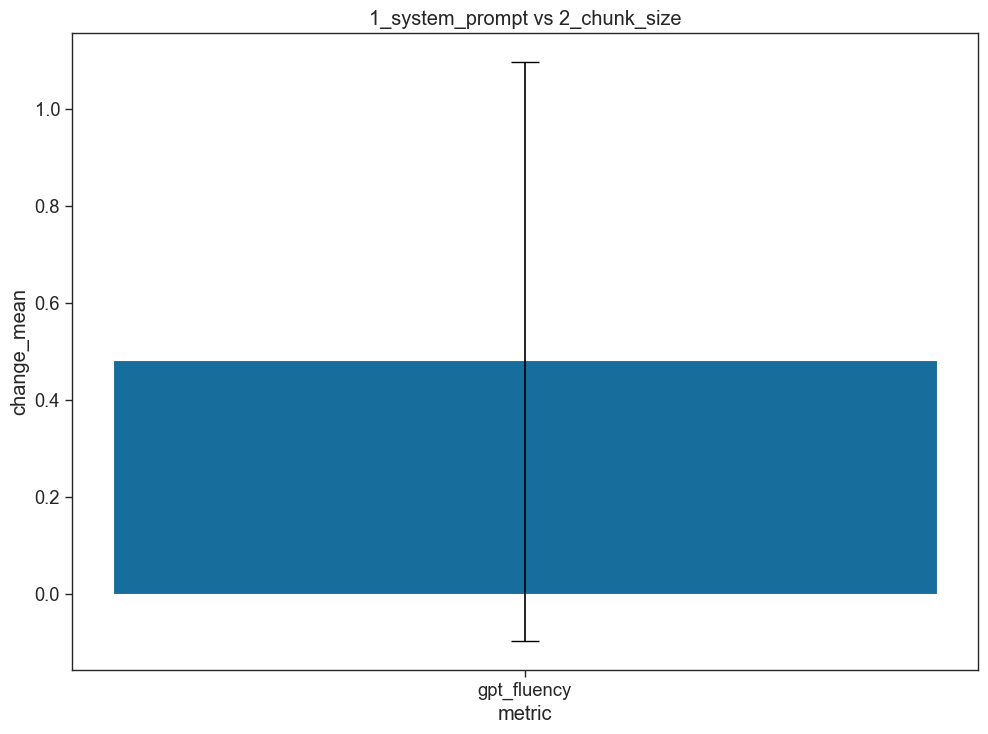

In [131]:
# plot a bar chart for each metric that shows the change in the metric with error bars
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_palette("colorblind")
sns.set_context("paper", font_scale=1.5)
# draw a bar chart for one metric (just on bar)
record = results_df.iloc[5]
metric = record['metric']
control = record['control']
treatment = record['treatment']
control_mean = record['control_mean']
treatment_mean = record['treatment_mean']
change_mean = record['change_mean']
p_value = record['p_value']
ci_low = record['ci_low']
ci_high = record['ci_high']
# create a bar chart
ax = sns.barplot(x="metric", y="change_mean", data=record.to_frame().T)
# add the error bars
ax.errorbar(x=0, y=change_mean, yerr=[[change_mean-ci_low], [ci_high-change_mean]], fmt='none', c='black', capsize=10)
# add the name of the control and treatment as a title
ax.set_title(control + " vs " + treatment)
# save the plot
#plt.savefig('change.png')





TypeError: seaborn.categorical.barplot() got multiple values for keyword argument 'x'

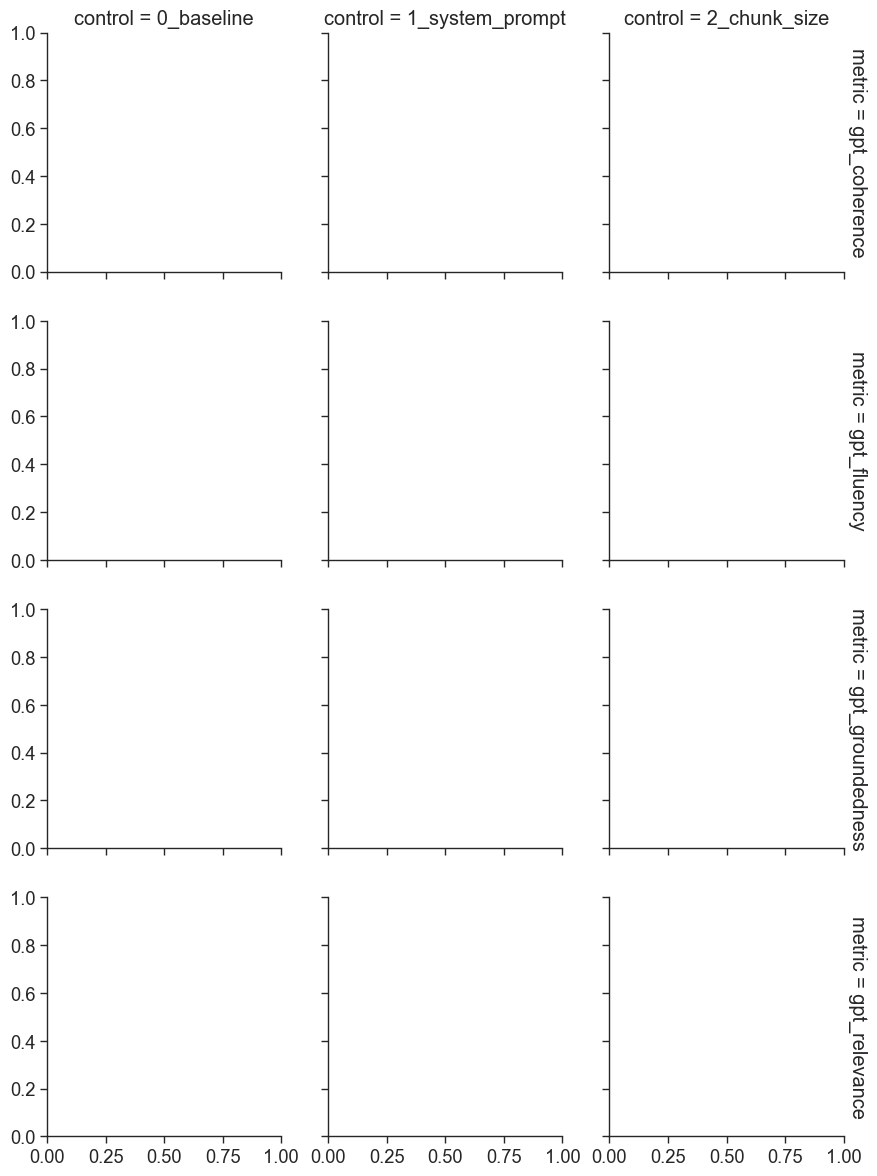

In [132]:
# plot a bar chart for each metric that shows the change in the metric with error bars
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_palette("colorblind")
sns.set_context("paper", font_scale=1.5)

# create a FacetGrid with one row for each metric and one column for each comparison
g = sns.FacetGrid(results_df, row='metric', col='control', margin_titles=True)

# define a function to plot the bar chart for each facet
def plot_bar_chart(data, **kwargs):
    ax = sns.barplot(x="treatment", y="change_mean", data=data, **kwargs)
    ax.errorbar(x=range(len(data)), y=data['change_mean'], yerr=[[data['change_mean']-data['ci_low']], [data['ci_high']-data['change_mean']]], fmt='none', c='black', capsize=10)
    ax.set_title(data['control'].iloc[0] + " vs " + data['treatment'].iloc[0])

# map the plot function to each facet of the FacetGrid
g.map_dataframe(plot_bar_chart, x="treatment")

# adjust the layout of the FacetGrid
g.fig.tight_layout()

# save the plot
plt.savefig('change.png')